# Model building and testing

We shall begin with a linear model baseline, then move to gamma and log-normal models. All models will use stepwise variable selection and ridge regularization to account for multicolinearity and outliers.

In [54]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as ss

In [2]:
full_data = pd.read_csv("data/clean_data_sell.csv")
full_data

,property_code,property_type,property_subtype,sale_price,bedrooms,bathrooms,parking_spaces,area_util,area_total,condominium_fee,...,has_sauna,has_party_room,has_sports_court,has_24h_security,has_laundry,has_closet,has_office,has_pantry,size_category,amenity_score
0,84981-S,Casa,Padrão,298000.0,2,1,2,87.0,125.0,0.0,...,False,False,False,False,True,False,False,False,medium,0
1,84976-S,Casa,Padrão,630000.0,2,2,2,206.0,229.0,0.0,...,False,False,False,False,True,False,False,True,extra_large,0
2,84968-S,Casa,Casa de Condomínio,235000.0,3,1,2,60.0,100.0,215.0,...,False,True,False,True,True,False,False,False,medium,4
3,84962-S,Casa,Padrão,330000.0,2,2,2,121.0,162.0,0.0,...,False,False,False,False,True,False,False,False,large,0
4,84930-S,Casa,Casa de Condomínio,1192000.0,3,1,8,246.0,1022.0,270.0,...,False,False,False,False,True,True,False,True,extra_large,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3872,550-S,Apartamento,Padrão,230000.0,1,1,1,45.0,45.0,172.0,...,False,False,False,False,True,False,False,False,small,0
3873,376-S,Casa,Padrão,1000000.0,3,1,2,288.0,190.0,0.0,...,False,False,False,False,True,False,True,False,extra_large,0
3874,224-S,Casa,Padrão,750000.0,3,1,2,158.0,250.0,0.0,...,False,False,False,False,True,False,False,False,large,0
3875,162-S,Casa,Padrão,446809.0,3,2,2,160.0,170.0,0.0,...,False,False,False,False,True,False,False,False,large,0


## Pre-processing

We shall use standardization, so that all variables are on the same scale, and exponential features (for area) don't cause overflows.

In [31]:
std_data : pd.DataFrame = full_data.copy()
num_cols = std_data.select_dtypes(include = "number").drop(columns=["sale_price", "area_util", "area_total", "condominium_fee"]).columns

stdize = lambda series, lim : (series - ss.tmean(series, limits=(None, lim))) / ss.tstd(series, limits=(None, lim))
# Trimmed mean used to reduce influence of big outliers and asymmetry
std_data["area_util"] = stdize(std_data["area_util"], 1000)
std_data["area_total"] = stdize(std_data["area_total"], 1000)
std_data["condominium_fee"] = stdize(std_data["condominium_fee"], 1700)
# To avoid exploding values (houses are expensive, arent they?)
std_data["sale_price"] = std_data["sale_price"] / 10**5

# theres one big fckin outlier (how da fuck is it 10k after standardizing????)
std_data = std_data.query("area_total < 10000")

std_data["exp(area_util)"] = np.exp(std_data["area_util"])
std_data["exp(area_total)"] = np.exp(std_data["area_total"])

for col in num_cols:
    std_data[col] = stdize(std_data[col], ss.quantile(std_data[col], 0.80))
std_data

,property_code,property_type,property_subtype,sale_price,bedrooms,bathrooms,parking_spaces,area_util,area_total,condominium_fee,...,has_sports_court,has_24h_security,has_laundry,has_closet,has_office,has_pantry,size_category,amenity_score,exp(area_util),exp(area_total)
0,84981-S,Casa,Padrão,2.98000,-0.585413,-0.450750,0.982481,-0.491160,-0.419177,-0.590014,...,False,False,True,False,False,False,medium,-0.306466,0.611916,0.657588
1,84976-S,Casa,Padrão,6.30000,-0.585413,2.184567,0.982481,0.730679,0.265377,-0.590014,...,False,False,True,False,False,True,extra_large,-0.306466,2.076491,1.303922
2,84968-S,Casa,Casa de Condomínio,2.35000,1.049229,-0.450750,0.982481,-0.768384,-0.583733,0.288212,...,False,True,True,False,False,False,medium,13.967370,0.463762,0.557812
3,84962-S,Casa,Padrão,3.30000,-0.585413,2.184567,0.982481,-0.142063,-0.175634,-0.590014,...,False,False,True,False,False,False,large,-0.306466,0.867567,0.838925
4,84930-S,Casa,Casa de Condomínio,11.92000,1.049229,-0.450750,11.749423,1.141381,5.485098,0.512874,...,False,False,True,True,False,True,extra_large,-0.306466,3.131091,241.072615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3872,550-S,Apartamento,Padrão,2.30000,-2.220054,-0.450750,-0.812010,-0.922397,-0.945757,0.112567,...,False,False,True,False,False,False,small,-0.306466,0.397565,0.388386
3873,376-S,Casa,Padrão,10.00000,1.049229,-0.450750,0.982481,1.572619,0.008669,-0.590014,...,False,False,True,False,True,False,extra_large,-0.306466,4.819252,1.008707
3874,224-S,Casa,Padrão,7.50000,1.049229,-0.450750,0.982481,0.237837,0.403604,-0.590014,...,False,False,True,False,False,False,large,-0.306466,1.268502,1.497211
3875,162-S,Casa,Padrão,4.46809,1.049229,2.184567,0.982481,0.258372,-0.122976,-0.590014,...,False,False,True,False,False,False,large,-0.306466,1.294820,0.884285


## Baseline linear model



In [48]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error, r2_score
seed = 67
train, test = train_test_split(std_data, test_size = 0.2, random_state = seed)
# interaction terms chosen based on domain knowledge (pulled out of my ass)
# model = smf.ols(
#     formula = "sale_price ~ bedrooms + bathrooms + parking_spaces + np.exp(area_util)*C(property_type) + np.exp(area_total) * C(property_type) + condominium_fee + has_pool + has_bbq + has_playground +has_sauna + has_party_room + has_sports_court + has_24h_security + has_laundry + has_closet + has_office + has_pantry + amenity_score",
#     data = train
# )

model = smf.ols(
    formula = "sale_price ~ bedrooms + bathrooms + parking_spaces + area_total + C(property_type) + condominium_fee + has_pool + has_bbq + has_playground +has_sauna + has_party_room + has_sports_court + has_24h_security + has_laundry + has_closet + has_office + has_pantry + amenity_score",
    data = train
)

results = []

alpha_grid = np.logspace(-4, 5, 200)
k=0

fitted_ols = model.fit()

fitted_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             sale_price   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.544
Method:                 Least Squares   F-statistic:                     218.4
Date:                Sat, 22 Nov 2025   Prob (F-statistic):               0.00
Time:                        13:45:54   Log-Likelihood:                -8027.0
No. Observations:                3100   AIC:                         1.609e+04
Df Residuals:                    3082   BIC:                         1.620e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    4.2787      0.232     18.436      0.000       3.824       4.734
C(property_type)[T.Casa]     0.1705      0.174      0.978      0.328      -0.171       0.512
has_pool[T.True]             0.3468      0.281      1.233      0.218      -0.205       0.898
has_bbq[T.True]             -0.3249      0.252     -1.291      0.197      -0.818       0.168
has_playground[T.True]      -0.2941      0.314     -0.937      0.349      -0.910       0.322
has_sauna[T.True]            2.3042      0.640      3.598      0.000       1.048       3.560
has_party_room[T.True]      -1.0008      0.283     -3.534      0.000      -1.556      -0.445
has_sports_court[T.True]     0.6605      0.342      1.933      0.053      -0.009       1.330
has_24h_security[T.True]    -1.2693      0.259     -4.899      0.000      -1.777      -0.761
has_laundry[T.True]         -0.4702      0.218     -2.157      0.031      -0.898      -0.043
has_closet[T.True]           2.2936      0.219     10.473      0.000       1.864       2.723
has_office[T.True]           1.1639      0.227      5.131      0.000       0.719       1.609
has_pantry[T.True]           0.6858      0.174      3.946      0.000       0.345       1.027
bedrooms                     0.9049      0.054     16.756      0.000       0.799       1.011
bathrooms                    0.1495      0.038      3.955      0.000       0.075       0.224
parking_spaces               0.4294      0.029     14.963      0.000       0.373       0.486
area_total                   0.6224      0.039     15.926      0.000       0.546       0.699
condominium_fee              0.9838      0.067     14.710      0.000       0.853       1.115
amenity_score                0.1959      0.031      6.242      0.000       0.134       0.257
==============================================================================
Omnibus:                     2239.610   Durbin-Watson:                   1.919
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            85744.679
Skew:                           2.981   Prob(JB):                         0.00
Kurtosis:                      28.066   Cond. No.                     4.77e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.85e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

With a 0.546 R squared, we have a weakish fit to the data, but expected with real world data

In [50]:
def mse(model, test_data, y_col = "sale_price"):
    return mean_squared_error(model.predict(test_data), test_data[y_col])

def rmse(model, test_data, y_col = "sale_price"):
    return root_mean_squared_error(model.predict(test_data), test_data[y_col])

def mae(model, test_data, y_col = "sale_price"):
    return mean_absolute_error(model.predict(test_data), test_data[y_col])

def r2(model, test_data, y_col = "sale_price"):
    return r2_score(model.predict(test_data), test_data[y_col])


print("PREDICTIVE RESULTS FOR TRAIN DATA")
print(f"RMSE: {rmse(fitted_ols, train)}")
print(f"MAE: {mae(fitted_ols, train)}")
print(f"R2: {r2(fitted_ols, train)}")

print("PREDICTIVE RESULTS FOR TEST DATA")
print(f"RMSE: {rmse(fitted_ols, test)}")
print(f"MAE: {mae(fitted_ols, test)}")
print(f"R2: {r2(fitted_ols, test)}")

PREDICTIVE RESULTS FOR TRAIN DATA
RMSE: 3.223361605048263
MAE: 1.8698026913758516
R2: 0.16980149680745227
PREDICTIVE RESULTS FOR TEST DATA
RMSE: 3.837702142896372
MAE: 2.0230577049751184
R2: -0.14908506173574687


The R squared drops significantly (and is quite different between statsmodels and sklearn, will look into that) butt the error metrics keep kind of close, rememebring that the data has been scaled down, so we are looking at a 20k reais of mean absolute error. lets look at residual plots

In [93]:
fitted_ols.get_influence().hat_matrix_diag

array([0.01927646, 0.02760585, 0.00117949, ..., 0.00117395, 0.00106673,
       0.01152137], shape=(3100,))

Text(0, 0.5, 'Hat values (leverage)')

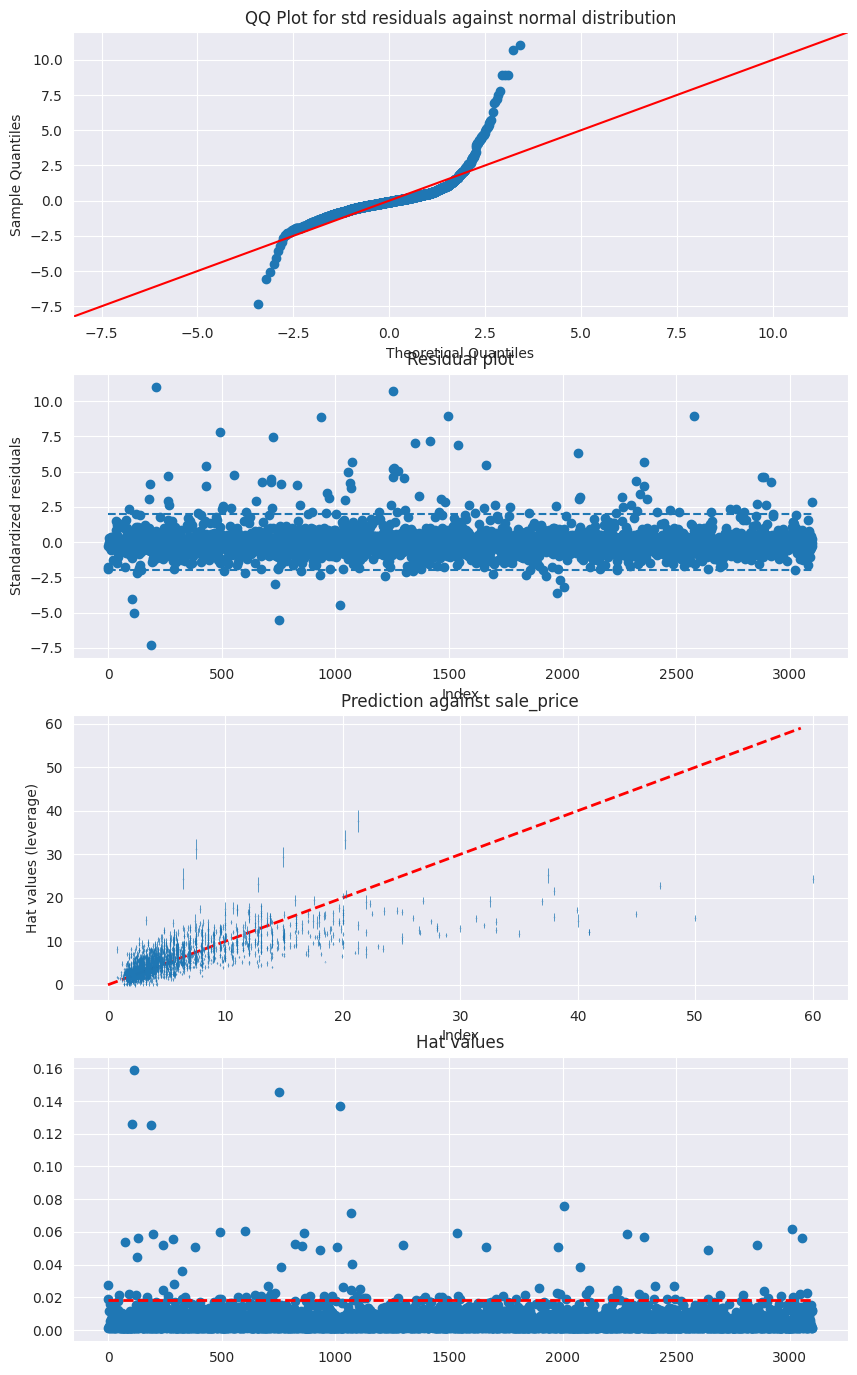

In [95]:
from statsmodels.graphics.gofplots import ProbPlot

std_residuals = fitted_ols.resid_pearson
pp = ProbPlot(std_residuals)
fig, axes = plt.subplots(4, 1, figsize = (10,17))
axes[0].set_title("QQ Plot for std residuals against normal distribution")
qq  = pp.qqplot(ax = axes[0], line="45")

axes[1].set_title("Residual plot")
axes[1].scatter(list(range(len(std_residuals))), std_residuals)
axes[1].hlines(y=[-2, 2], linestyles="dashed", xmin=0, xmax=len(std_residuals))
axes[1].set_xlabel("Index")
axes[1].set_ylabel("Standardized residuals")

axes[2].set_title("Prediction against sale_price")
pred_summary = fitted_ols.get_prediction().summary_frame()
errors = np.array(list(zip(pred_summary["mean"] - pred_summary["mean_ci_lower"], abs(pred_summary["mean"] - pred_summary["mean_ci_upper"])))).T
axes[2].plot(np.arange(0, 60, 1), np.arange(0, 60, 1), linestyle = "dashed", color = "red", linewidth = 2)
axes[2].errorbar(train["sale_price"], pred_summary["mean"], yerr = errors, fmt = "o", markersize=0.1, linewidth = 0.5)
axes[2].set_xlabel("Sale price")
axes[2].set_ylabel("Prediction")

hat = fitted_ols.get_influence().hat_matrix_diag
reference = 3 * len(fitted_ols.params) / len(train["sale_price"])
axes[3].set_title("Hat values")
axes[3].scatter(list(range(len(hat))), hat)
axes[3].hlines(y=reference, linestyles="dashed", xmin=0, xmax=len(hat), color = "red", linewidth = 2)
axes[2].set_xlabel("Index")
axes[2].set_ylabel("Hat values (leverage)")


Conclusions:
- Right asymmetrical and overdispersed residuals (indicates a gamma or lognormal model may fit better to data)
- Large portion of residuals falls inside 2 stddev
- Considerable number of outliers with poor predictions
- Mean response seems to affect disperson (bonus points to gamma regression)
- Few points with high leverage, indicates that the model probably isnt broken from them